In [12]:
# Audio preprocessing
import librosa
import soundfile as sf
import numpy as np
from pydub import AudioSegment
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

In [2]:
def load_audio(file_path, target_sr=16000):
    """
    Load a WAV audio file and resample it to a fixed sampling rate.
    
    Args:
        file_path (str): Path to the audio file.
        target_sr (int): Target sampling rate (default: 16kHz).
    
    Returns:
        y (numpy array): Audio waveform.
        sr (int): Sampling rate of the loaded audio.
    """
    y, sr = librosa.load(file_path, sr=target_sr)
    return y, sr

In [3]:
def rms_normalization(audio, target_rms=0.1):
    """
    Normalize the audio signal to a fixed RMS (Root Mean Square) value.

    Args:
        audio (numpy array): Input audio waveform.
        target_rms (float): Target RMS level.

    Returns:
        y_norm (numpy array): RMS-normalized audio waveform.
    """
    rms = np.sqrt(np.mean(audio**2))  # Compute current RMS
    scaling_factor = target_rms / (rms + 1e-10)  # Avoid division by zero
    y_norm = audio * scaling_factor  # Scale audio to match target RMS

    return y_norm

In [7]:
def calculate_features(audio_path):
    y, sr = load_audio(audio_path)  # Load and resample
    y_norm = rms_normalization(y)  # Normalize volume
    features = {}
    # --- 1. MFCCs ---
    mfccs = librosa.feature.mfcc(y=y_norm, sr=sr, n_mfcc=13)
    mfccs_mean = np.mean(mfccs, axis=1)
    features['mfccs'] = mfccs_mean
    
    # --- 2. Spectral Entropy ---
    spec = np.abs(librosa.stft(y_norm, n_fft=2048))
    col_sums = np.sum(spec, axis=0, keepdims=True)

    # Prevent division by zero
    col_sums[col_sums == 0] = 1e-10
    prob_dist = spec / col_sums

    entropy = -np.sum(prob_dist * np.log2(prob_dist + 1e-10), axis=0)
    features['spectral_entropy'] = np.mean(entropy)

    
    # --- 3. Zero-Crossing Rate ---
    zcr = librosa.feature.zero_crossing_rate(y_norm)
    features['zcr'] = np.mean(zcr)
    
    # --- 4. Spectral Centroid ---
    centroid = librosa.feature.spectral_centroid(y=y_norm, sr=sr)
    features['spectral_centroid'] = np.mean(centroid)
    
    # ✅ 5. Spectral Bandwidth
    spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y_norm, sr=sr)
    bandwidth_mean = np.mean(spectral_bandwidth)
    features['spectral_bandwith'] = bandwidth_mean
    
     # Combine into a single feature vector
    feature_vector = np.concatenate([
        features['mfccs'],
        [features['spectral_entropy']],
        [features['zcr']],
        [features['spectral_centroid']],
        [features['spectral_bandwith']]
    ])
    return feature_vector

In [8]:
audios = [
    'output_audios/audio1.wav',
    'output_audios/audio2.wav',
    'output_audios/audio3.wav',
    'output_audios/audio4.wav',
    'output_audios/audio6.wav',
    'output_audios/audio7.wav',
    'output_audios/audio8.wav',
    'output_audios/audio9.wav',
    'output_audios/audio10.wav',
    'output_audios/audio11.wav',
    'output_audios/audio12.wav',
    'output_audios/audio13.wav',
    'output_audios/audio14.wav',
    'output_audios/audio15.wav',
    'output_audios/audio16.wav',
    'output_audios/audio17.wav',
    'output_audios/9 Apr, 3.21 pm.wav',
    'output_audios/New recording 21.wav',
]
X = [calculate_features(audio) for audio in audios]

In [9]:
print(X)

[array([-1.15282898e+02,  1.33760696e+02, -2.47462921e+01,  4.56455803e+01,
       -2.85112019e+01,  1.40439081e+01, -1.89290295e+01,  2.23694038e+01,
       -1.23675194e+01,  7.94238997e+00, -1.11199665e+01,  5.90307570e+00,
       -3.29176235e+00,  8.24116039e+00,  1.03917321e-01,  1.32087362e+03,
        1.37870095e+03]), array([-1.42581100e+02,  1.51977066e+02, -7.94221725e+01,  3.86721725e+01,
       -3.52597351e+01, -1.77924156e+01, -9.13916969e+00, -2.54057903e+01,
       -5.53045416e+00, -1.61189728e+01, -7.76212549e+00, -1.53763056e+01,
       -1.14548378e+01,  8.15157223e+00,  1.07477232e-01,  1.30460807e+03,
        1.08008023e+03]), array([-9.32346649e+01,  6.71615219e+01, -4.60623970e+01,  9.22339916e+00,
       -8.21910095e+00, -1.41167796e+00,  4.60120678e+00, -6.97902441e-01,
       -1.12732925e+01,  4.84043550e+00, -8.19958591e+00, -3.59120011e+00,
       -1.75857043e+00,  8.57074928e+00,  2.09018441e-01,  2.05595671e+03,
        1.59471832e+03]), array([-6.04351997e+0

In [10]:
X = np.array(X)

In [13]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled

array([[-0.17482072,  0.77559854, -0.99996861,  2.43671443, -2.20472672,
         1.30467502, -1.49831771,  2.16868705, -1.30646695,  0.98427131,
        -1.31960905,  1.09603943,  2.14206362, -0.11700067,  0.27754828,
        -0.25890248, -1.38836231],
       [-1.2450281 ,  1.64712369, -3.07166999,  1.90781205, -2.98228927,
        -1.81983629, -0.0629661 , -2.11671504,  0.54971014, -2.10664283,
         1.10644261, -2.52085608, -0.60039582, -0.42585037,  0.3614919 ,
        -0.31266035, -2.95865329],
       [ 0.68956518, -2.41070351, -1.8076484 , -0.32574821,  0.13331877,
        -0.21218207,  1.95159509,  0.09956553, -1.00939815,  0.58579534,
         0.79037596, -0.51772006,  2.65715339,  1.0192368 ,  2.75585982,
         2.17055786, -0.25243936],
       [ 1.9754458 , -1.98445791, -0.54778921,  1.10319551,  1.00199282,
         1.8530081 ,  2.4766873 ,  0.6550067 ,  2.7867824 ,  1.37695268,
         2.14976565,  1.0914083 ,  1.14077286,  2.04765961,  1.78110303,
         1.91179826

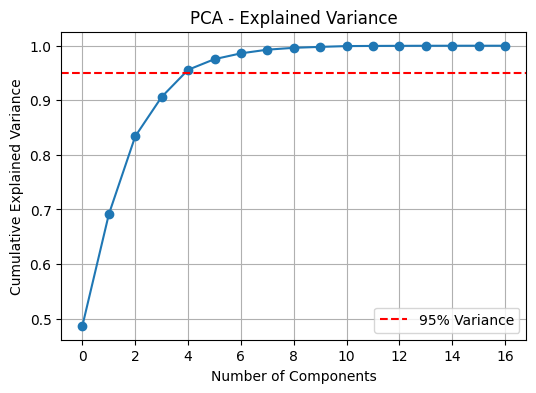

📉 Number of components to retain 95% variance: 5


In [14]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Assume X_scaled is your scaled (standardized) 1024-dim embeddings
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Plot explained variance
plt.figure(figsize=(6, 4))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA - Explained Variance')
plt.grid(True)
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Variance')
plt.legend()
plt.show()

# Get number of components to retain 95% variance
n_components_95 = np.argmax(np.cumsum(pca.explained_variance_ratio_) >= 0.95) + 1
print(f"📉 Number of components to retain 95% variance: {n_components_95}")

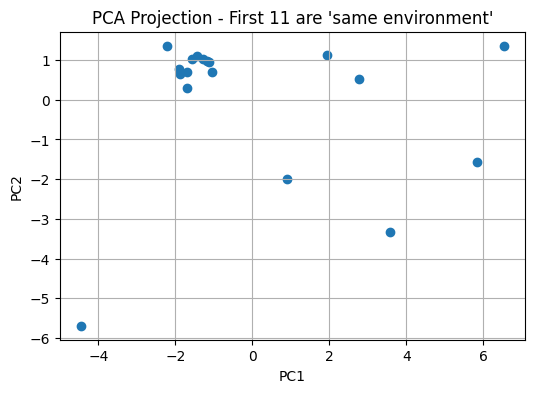

In [17]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=5)
X_pca = pca.fit_transform(X_scaled)

# Visualize: color first 11 as one group

plt.figure(figsize=(6,4))
plt.scatter(X_pca[:,0], X_pca[:,1])
plt.title("PCA Projection - First 11 are 'same environment'")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.show()

In [ ]:
from sklearn.neighbors import NearestNeighbors
from kneed import KneeLocator
import matplotlib.pyplot as plt
import numpy as np

# Let's say X_2d is your data after PCA (shape: [n_samples, n_components])
k = 2  # min_samples for DBSCAN (or set to any expected density threshold)

# Step 1: Fit Nearest Neighbors model
neighbors = NearestNeighbors(n_neighbors=k)
neighbors_fit = neighbors.fit(X_pca)

# Step 2: Calculate distances to the k-th nearest neighbor
distances, indices = neighbors_fit.kneighbors(X_pca)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
# Step 3: Find elbow point (i.e. best eps)
kneedle = KneeLocator(
    range(len(distances)),
    distances,
    curve="convex",
    direction="increasing",
    S=2# Try decreasing this sensitivity parameter
)

# Step 4: This is your automated eps
epsilon = distances[kneedle.elbow]
print("🔍 Chosen eps:", epsilon)

# Optional: Plot the knee
plt.plot(distances)
plt.axvline(x=kneedle.elbow, color='red', linestyle='--')
plt.title("K-distance Graph")
plt.xlabel("Sorted points")
plt.ylabel("Distance to {}th neighbor".format(k))
plt.show()
distances_array = np.array(distances)
acceleration = np.diff(np.diff(distances_array))
elbow_index = np.argmax(acceleration) + 1
epsilon = distances[elbow_index]
print(epsilon)

🔍 Chosen eps: 1.1317262266825312


In [43]:
from sklearn.cluster import DBSCAN

clusterer = DBSCAN(eps=2.6989701148049288, min_samples=2)
labels = clusterer.fit_predict(X_pca)
labels

array([-1, -1, -1, -1, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,
        1])